In [1]:
import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.metrics import confusion_matrix, f1_score

train = pd.read_csv('../training_data/training_set.csv')
val = pd.read_csv('../safe_data/safe_data.csv')
locations = train['Location'].unique()

In [18]:
print(train.shape)
print(val.shape)

(109641, 24)
(32552, 24)


In [2]:
# convert to binary
def format_data(data):
    data["RainTomorrow"].replace(('Yes', 'No'), (1, 0), inplace=True)
    data["RainToday"].replace(('Yes', 'No'), (1, 0), inplace=True)
    data.drop(columns=['Location', 'Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm', 'RISK_MM'], inplace=True)
    # convert direction strings to degrees
    data['WindGustDir'].replace(
        ('N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW','SW','WSW','W','WNW','NW','NNW'),
        (0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5),
        inplace=True)
    data['WindDir9am'].replace(
        ('N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW','SW','WSW','W','WNW','NW','NNW'),
        (0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5),
        inplace=True)
    data['WindDir3pm'].replace(
        ('N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW','SW','WSW','W','WNW','NW','NNW'),
        (0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5),
        inplace=True)
    data.dropna(
        axis=0, how='any',
        subset=['WindGustDir','WindDir9am','WindDir3pm','WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm'],
        inplace=True)
    data.dropna(axis=0, how='any', inplace=True)
    data_date = pd.to_datetime(data.pop('Date'))
    wv = data.pop('WindGustSpeed')
    wd = data.pop('WindGustDir')*np.pi/180
    data['WindGustX'] = wv*np.cos(wd)
    data['WindGustY'] = wv*np.sin(wd)
    wv = data.pop('WindSpeed9am')
    wd = data.pop('WindDir9am')*np.pi/180
    data['Wind9amX'] = wv*np.cos(wd)
    data['Wind9amY'] = wv*np.sin(wd)
    wv = data.pop('WindSpeed3pm')
    wd = data.pop('WindDir3pm')*np.pi/180
    data['Wind3pmX'] = wv*np.cos(wd)
    data['Wind3pmY'] = wv*np.sin(wd)
    timestamp_s = data_date.map(datetime.datetime.timestamp)
    day = 24*60*60
    year = (365.2425)*day
    data['yearsin'] = np.sin(timestamp_s * (2 * np.pi/year))
    data['yearcos'] = np.cos(timestamp_s * (2 * np.pi/year))
    return data

In [3]:
# https://www.tensorflow.org/tutorials/structured_data/time_series#1_indexes_and_offsets
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None, batch_size=32):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns],axis=-1)
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels
    
    def plot(self, model=None, plot_col='RainTomorrow', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        predictions = 0
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],label='Inputs', marker='.', zorder=-10)
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else: label_col_index = plot_col_index
            if label_col_index is None: continue
            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
            if n == 0: plt.legend()
        plt.xlabel('Time [h]')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=batch_size,)
        ds = ds.map(self.split_window)
        return ds
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result

In [4]:
def visual_cm(y_train, y_pred, model_name):
    cm = confusion_matrix(y_train, y_pred,labels = [1,0])
    group_names = ['TP','FN','FP','TN']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plot = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels = [1,0], yticklabels = ['Rain','No Rain'])
    plot.set_title(model_name)
    plot.get_figure().savefig(f'img/{model_name}_conf.png')
    sensitivity = "{0:.2%}".format(cm[0,0]/(cm[0,0]+cm[0,1]))
    specificity = "{0:.2%}".format(cm[1,1]/(cm[1,0]+cm[1,1]))
    print("Sensitivity(ability to detect rain in rainy days):", sensitivity)
    print("Specificity(ability to detect Not rain in normal days):",specificity)
    print("f1 score:", f1_score(y_train, y_pred))

def results(model, model_name, window, cutoff=0.5, window_offset=7):
    
    y_train = np.array(window.val_df[window_offset:]['RainTomorrow'])
    y_pred = model.predict(window.val)
    y_pred = y_pred.reshape(y_pred.shape[0])
    
    fpr, tpr, thresholds = sk.metrics.roc_curve(y_train, y_pred)
    roc_auc = sk.metrics.auc(fpr, tpr)
    print("Area under the ROC curve : %f" % roc_auc)
    
    i = np.arange(len(tpr))
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
    roc_metrics = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    
    y_pred = np.array([(x>cutoff).astype("int32") for x in y_pred])
    count = 0
    for i in range(0,y_pred.shape[0]):
        if ((y_pred[i]-y_train[i])**2) == 0: count+=1
    print(f'Raw accuracy: {count/y_pred.shape[0]}')
    
    visual_cm(y_train, y_pred)

In [5]:
data = train.copy(deep=True)
data = format_data(data)

val_data = val.copy(deep=True)
val_data = format_data(val_data)

n = len(data)
train_df = data
val_df = val_data
test_df = data

cols_to_norm = list(data.columns)
cols_to_norm.remove('RainToday')
cols_to_norm.remove('RainTomorrow')

train_mean = train_df[cols_to_norm].mean()
train_std = train_df[cols_to_norm].std()

train_df.loc[:,cols_to_norm] = (train_df.loc[:,cols_to_norm] - train_mean) / train_std
val_df.loc[:,cols_to_norm] = (val_df.loc[:,cols_to_norm] - train_mean) / train_std
test_df.loc[:,cols_to_norm] = (test_df.loc[:,cols_to_norm] - train_mean) / train_std

In [6]:
batch_size = 32
def compile_and_fit(model, window, lr=0.00001, patience=2, epochs=15):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', min_delta=0.0005, patience=patience, mode='max')
    model.compile(loss=tf.losses.BinaryCrossentropy(), optimizer=tf.optimizers.Adam(lr=lr),
        metrics=[tf.metrics.BinaryAccuracy()])    
    history = model.fit(window.train, epochs=epochs, validation_data=window.val, callbacks=[early_stopping], verbose=2)
    return history

loss = {}
acc = {}

In [7]:
def plot_results(name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axes[0].plot(acc[name][0])
    axes[0].plot(acc[name][1])
    axes[0].title.set_text(f'{name} model accuracy')
    axes[0].legend(['train', 'test'], loc='lower right')
    axes[1].plot(loss[name][0])
    axes[1].plot(loss[name][1])
    axes[1].title.set_text(f'{name} model loss')
    axes[1].legend(['train', 'test'], loc='lower right')
    fig.savefig(f'img/{name}_metrics.png')

Epoch 1/15
2722/2722 - 10s - loss: 38.4708 - binary_accuracy: 0.2189 - val_loss: 0.8103 - val_binary_accuracy: 0.5358
Epoch 2/15
2722/2722 - 10s - loss: 31.9413 - binary_accuracy: 0.2189 - val_loss: 0.7934 - val_binary_accuracy: 0.5426
Epoch 3/15
2722/2722 - 10s - loss: 25.4127 - binary_accuracy: 0.2189 - val_loss: 0.7791 - val_binary_accuracy: 0.5506
Epoch 4/15
2722/2722 - 10s - loss: 18.8838 - binary_accuracy: 0.2189 - val_loss: 0.7675 - val_binary_accuracy: 0.5575
Epoch 5/15
2722/2722 - 10s - loss: 12.3542 - binary_accuracy: 0.2189 - val_loss: 0.7585 - val_binary_accuracy: 0.5662
Epoch 6/15
2722/2722 - 10s - loss: 5.8332 - binary_accuracy: 0.2189 - val_loss: 0.7523 - val_binary_accuracy: 0.5724
Epoch 7/15
2722/2722 - 9s - loss: 0.9998 - binary_accuracy: 0.4997 - val_loss: 0.7499 - val_binary_accuracy: 0.5762
Epoch 8/15
2722/2722 - 10s - loss: 0.5060 - binary_accuracy: 0.7811 - val_loss: 0.7503 - val_binary_accuracy: 0.5766
Epoch 9/15
2722/2722 - 10s - loss: 0.5046 - binary_accuracy:

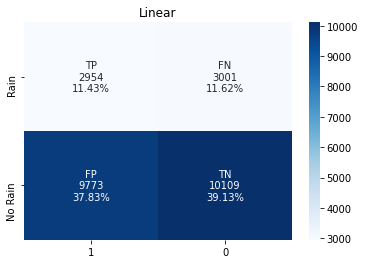

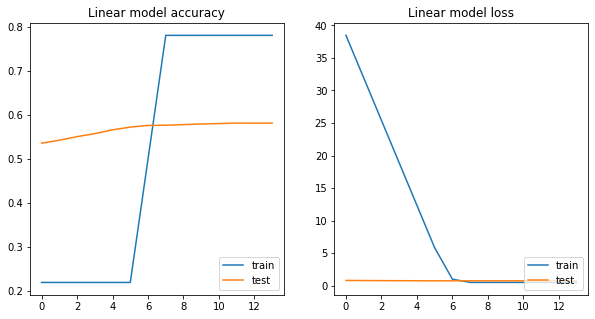

In [11]:
w = WindowGenerator(input_width=1, label_width=1, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['RainTomorrow'])
linear_model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

history = compile_and_fit(linear_model, w)
loss['Linear'] = [ history.history['loss'],history.history['val_loss'] ]
acc['Linear'] = [ history.history['binary_accuracy'],history.history['val_binary_accuracy'] ]

results(linear_model, 'Linear', w, window_offset=1)
plot_results('Linear')

Epoch 1/15
2722/2722 - 15s - loss: 1.0502 - binary_accuracy: 0.2189 - val_loss: 0.6593 - val_binary_accuracy: 0.6474
Epoch 2/15
2722/2722 - 14s - loss: 0.6488 - binary_accuracy: 0.6175 - val_loss: 0.6436 - val_binary_accuracy: 0.7176
Epoch 3/15
2722/2722 - 11s - loss: 0.5344 - binary_accuracy: 0.7811 - val_loss: 0.6375 - val_binary_accuracy: 0.7396
Epoch 4/15
2722/2722 - 14s - loss: 0.5273 - binary_accuracy: 0.7811 - val_loss: 0.6367 - val_binary_accuracy: 0.7423
Epoch 5/15
2722/2722 - 11s - loss: 0.5271 - binary_accuracy: 0.7811 - val_loss: 0.6365 - val_binary_accuracy: 0.7434
Epoch 6/15
2722/2722 - 11s - loss: 0.5269 - binary_accuracy: 0.7811 - val_loss: 0.6363 - val_binary_accuracy: 0.7442
Epoch 7/15
2722/2722 - 12s - loss: 0.5267 - binary_accuracy: 0.7811 - val_loss: 0.6361 - val_binary_accuracy: 0.7452
Epoch 8/15
2722/2722 - 12s - loss: 0.5265 - binary_accuracy: 0.7811 - val_loss: 0.6360 - val_binary_accuracy: 0.7456
Epoch 9/15
2722/2722 - 11s - loss: 0.5264 - binary_accuracy: 0.7

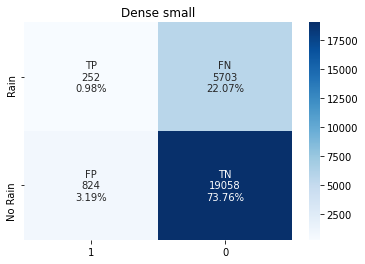

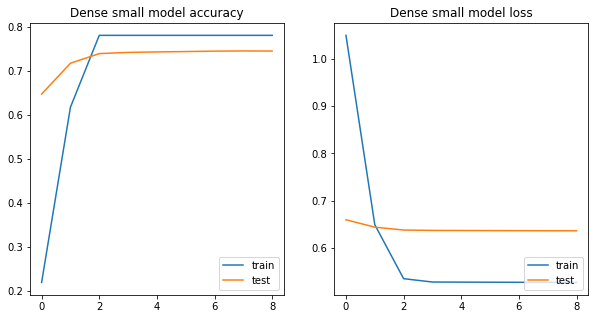

In [13]:
w = WindowGenerator(input_width=1, label_width=1, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['RainTomorrow'])
dense_model_small = keras.Sequential([
    keras.layers.Dense(units=4, activation='relu'),
    keras.layers.Dense(units=8, activation='relu'),
    keras.layers.Dense(units=1, activation='sigmoid')
])

history = compile_and_fit(dense_model_small, w)
loss['Dense small'] = [ history.history['loss'],history.history['val_loss'] ]
acc['Dense small'] = [ history.history['binary_accuracy'],history.history['val_binary_accuracy'] ]
results(dense_model_small, 'Dense small', w, window_offset=1)
plot_results('Dense small')

Epoch 1/15
2722/2722 - 14s - loss: 0.7118 - binary_accuracy: 0.7444 - val_loss: 0.6911 - val_binary_accuracy: 0.5365
Epoch 2/15
2722/2722 - 13s - loss: 0.5163 - binary_accuracy: 0.7811 - val_loss: 0.6915 - val_binary_accuracy: 0.5353
Epoch 3/15
2722/2722 - 13s - loss: 0.5108 - binary_accuracy: 0.7811 - val_loss: 0.6915 - val_binary_accuracy: 0.5349
Area under the ROC curve : 0.494370
Raw accuracy: 0.5057862754963811
Sensitivity(ability to detect rain in rainy days): 47.74%
Specificity(ability to detect Not rain in normal days): 51.43%
f1 score: 0.3081007856949336


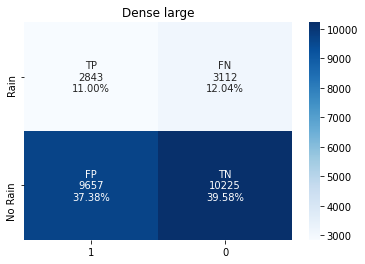

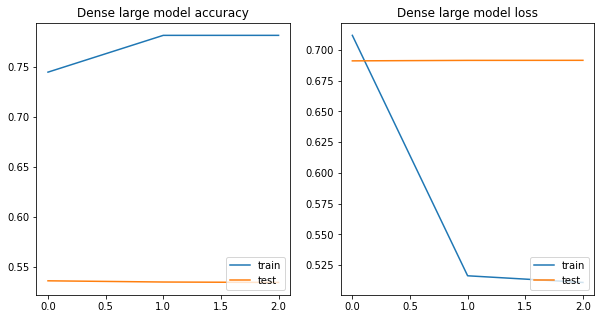

In [16]:
w = WindowGenerator(input_width=1, label_width=1, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['RainTomorrow'])
dense_model_large = keras.Sequential([
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=1, activation='sigmoid')
])

history = compile_and_fit(dense_model_large, w)
loss['Dense large'] = [ history.history['loss'],history.history['val_loss'] ]
acc['Dense large'] = [ history.history['binary_accuracy'],history.history['val_binary_accuracy'] ]
results(dense_model_large, 'Dense large', w, window_offset=1)
plot_results('Dense large')

Epoch 1/15
2722/2722 - 16s - loss: 11.9110 - binary_accuracy: 0.2189 - val_loss: 1.1034 - val_binary_accuracy: 0.2350
Epoch 2/15
2722/2722 - 13s - loss: 11.9110 - binary_accuracy: 0.2189 - val_loss: 1.1034 - val_binary_accuracy: 0.2350
Epoch 3/15
2722/2722 - 15s - loss: 11.9110 - binary_accuracy: 0.2189 - val_loss: 1.1034 - val_binary_accuracy: 0.2350
Area under the ROC curve : 0.497794
Raw accuracy: 0.23541481166040804
Sensitivity(ability to detect rain in rainy days): 98.72%
Specificity(ability to detect Not rain in normal days): 1.02%
f1 score: 0.3731352758204786


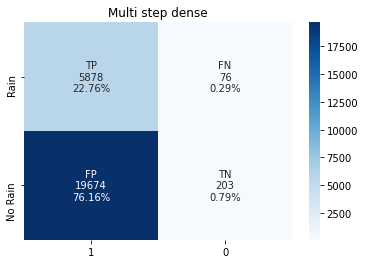

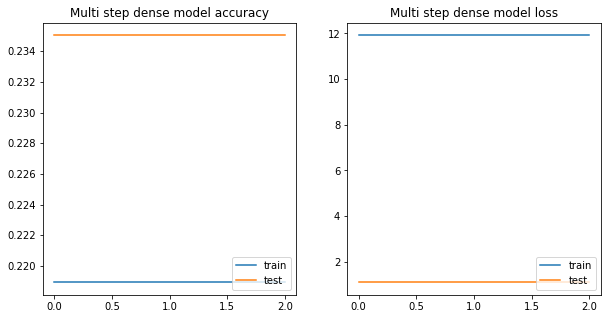

In [19]:
w = WindowGenerator(input_width=7, label_width=1, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['RainTomorrow'])
multi_dense_model = keras.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=1, activation='sigmoid'),
    keras.layers.Reshape([1, -1])
])

history = compile_and_fit(multi_dense_model, w)
loss['Multi step dense'] = [ history.history['loss'],history.history['val_loss'] ]
acc['Multi step dense'] = [ history.history['binary_accuracy'],history.history['val_binary_accuracy'] ]
results(multi_dense_model, 'Multi step dense', w)
plot_results('Multi step dense')

Epoch 1/15
2722/2722 - 14s - loss: 1.0091 - binary_accuracy: 0.7811 - val_loss: 0.7388 - val_binary_accuracy: 0.3753
Epoch 2/15
2722/2722 - 13s - loss: 0.5244 - binary_accuracy: 0.7811 - val_loss: 0.7383 - val_binary_accuracy: 0.3773
Epoch 3/15
2722/2722 - 14s - loss: 0.5235 - binary_accuracy: 0.7811 - val_loss: 0.7374 - val_binary_accuracy: 0.3780
Epoch 4/15
2722/2722 - 13s - loss: 0.5228 - binary_accuracy: 0.7811 - val_loss: 0.7365 - val_binary_accuracy: 0.3793
Epoch 5/15
2722/2722 - 13s - loss: 0.5222 - binary_accuracy: 0.7811 - val_loss: 0.7357 - val_binary_accuracy: 0.3802
Epoch 6/15
2722/2722 - 16s - loss: 0.5216 - binary_accuracy: 0.7811 - val_loss: 0.7348 - val_binary_accuracy: 0.3816
Epoch 7/15
2722/2722 - 20s - loss: 0.5211 - binary_accuracy: 0.7811 - val_loss: 0.7339 - val_binary_accuracy: 0.3831
Epoch 8/15
2722/2722 - 17s - loss: 0.5205 - binary_accuracy: 0.7811 - val_loss: 0.7331 - val_binary_accuracy: 0.3834
Epoch 9/15
2722/2722 - 19s - loss: 0.5199 - binary_accuracy: 0.7

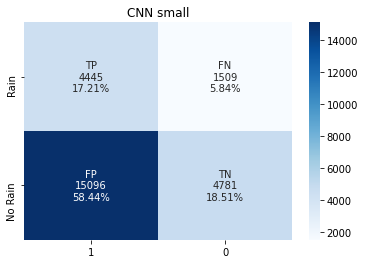

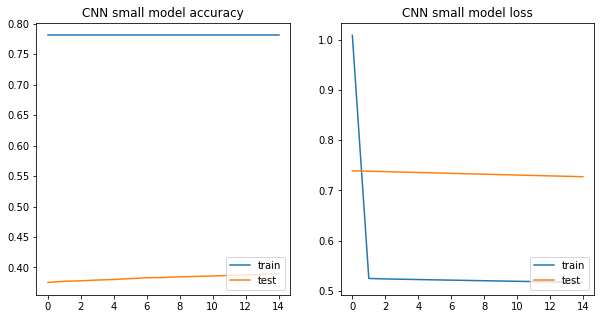

In [36]:
w = WindowGenerator(input_width=7, label_width=1, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['RainTomorrow'])
cnn_model_small = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=4, kernel_size=7, activation='relu'),
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

history = compile_and_fit(cnn_model_small, w)
loss['CNN small'] = [ history.history['loss'],history.history['val_loss'] ]
acc['CNN small'] = [ history.history['binary_accuracy'],history.history['val_binary_accuracy'] ]
results(cnn_model_small, 'CNN small', w)
plot_results('CNN small')

Epoch 1/15
2722/2722 - 15s - loss: 0.5172 - binary_accuracy: 0.7792 - val_loss: 0.6805 - val_binary_accuracy: 0.5769
Epoch 2/15
2722/2722 - 15s - loss: 0.4951 - binary_accuracy: 0.7827 - val_loss: 0.6763 - val_binary_accuracy: 0.5749
Epoch 3/15
2722/2722 - 14s - loss: 0.4824 - binary_accuracy: 0.7845 - val_loss: 0.6913 - val_binary_accuracy: 0.5737
Area under the ROC curve : 0.492775
Raw accuracy: 0.48701173009175025
Sensitivity(ability to detect rain in rainy days): 51.39%
Specificity(ability to detect Not rain in normal days): 47.89%
f1 score: 0.3159361932786124


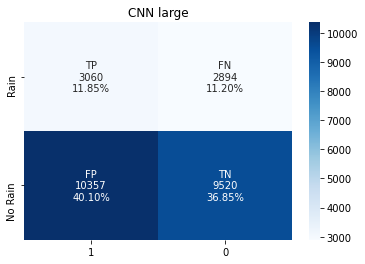

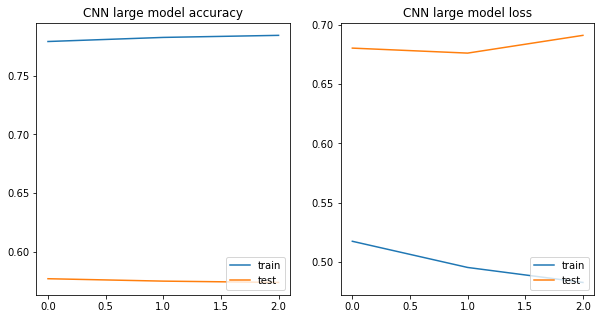

In [32]:
w = WindowGenerator(input_width=7, label_width=1, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['RainTomorrow'])
cnn_model_large = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=7, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

history = compile_and_fit(cnn_model_large, w, lr=0.001)
loss['CNN large'] = [ history.history['loss'],history.history['val_loss'] ]
acc['CNN large'] = [ history.history['binary_accuracy'],history.history['val_binary_accuracy'] ]
results(cnn_model_large, 'CNN large', w)
plot_results('CNN large')

Epoch 1/15
2722/2722 - 21s - loss: 0.5257 - binary_accuracy: 0.7810 - val_loss: 0.7128 - val_binary_accuracy: 0.5346
Epoch 2/15
2722/2722 - 20s - loss: 0.5195 - binary_accuracy: 0.7811 - val_loss: 0.7058 - val_binary_accuracy: 0.5462
Epoch 3/15
2722/2722 - 20s - loss: 0.5132 - binary_accuracy: 0.7811 - val_loss: 0.6995 - val_binary_accuracy: 0.5555
Epoch 4/15
2722/2722 - 20s - loss: 0.5076 - binary_accuracy: 0.7809 - val_loss: 0.6947 - val_binary_accuracy: 0.5643
Epoch 5/15
2722/2722 - 23s - loss: 0.5020 - binary_accuracy: 0.7808 - val_loss: 0.6907 - val_binary_accuracy: 0.5713
Epoch 6/15
2722/2722 - 20s - loss: 0.4970 - binary_accuracy: 0.7812 - val_loss: 0.6872 - val_binary_accuracy: 0.5763
Epoch 7/15
2722/2722 - 19s - loss: 0.4930 - binary_accuracy: 0.7810 - val_loss: 0.6838 - val_binary_accuracy: 0.5797
Epoch 8/15
2722/2722 - 20s - loss: 0.4893 - binary_accuracy: 0.7808 - val_loss: 0.6807 - val_binary_accuracy: 0.5835
Epoch 9/15
2722/2722 - 20s - loss: 0.4862 - binary_accuracy: 0.7

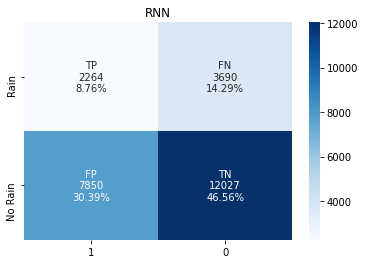

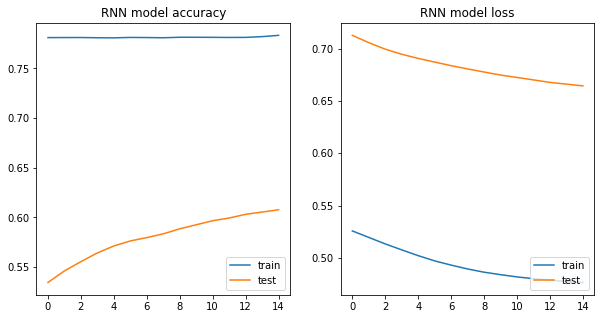

In [35]:
w = WindowGenerator(input_width=7, label_width=1, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['RainTomorrow'])
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8, return_sequences=False)),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])

history = compile_and_fit(lstm_model, w, lr=0.0001)
loss['RNN'] = [ history.history['loss'],history.history['val_loss'] ]
acc['RNN'] = [ history.history['binary_accuracy'],history.history['val_binary_accuracy'] ]
results(lstm_model, 'RNN', w)
plot_results('RNN')

Epoch 1/15
59/59 - 2s - loss: 0.8923 - binary_accuracy: 0.2144 - val_loss: 0.8586 - val_binary_accuracy: 0.2289
Epoch 2/15
59/59 - 1s - loss: 0.7021 - binary_accuracy: 0.5037 - val_loss: 0.5302 - val_binary_accuracy: 0.7856
Epoch 3/15
59/59 - 1s - loss: 0.5297 - binary_accuracy: 0.7856 - val_loss: 0.5293 - val_binary_accuracy: 0.7856
Epoch 4/15
59/59 - 1s - loss: 0.5290 - binary_accuracy: 0.7856 - val_loss: 0.5286 - val_binary_accuracy: 0.7856
Epoch 1/15
55/55 - 1s - loss: 0.9520 - binary_accuracy: 0.2021 - val_loss: 0.9472 - val_binary_accuracy: 0.2021
Epoch 2/15
55/55 - 1s - loss: 0.9429 - binary_accuracy: 0.2021 - val_loss: 0.9383 - val_binary_accuracy: 0.2021
Epoch 3/15
55/55 - 1s - loss: 0.9342 - binary_accuracy: 0.2021 - val_loss: 0.9297 - val_binary_accuracy: 0.2021
Epoch 1/15
70/70 - 1s - loss: 0.5331 - binary_accuracy: 0.8752 - val_loss: 0.5316 - val_binary_accuracy: 0.8752
Epoch 2/15
70/70 - 1s - loss: 0.5302 - binary_accuracy: 0.8752 - val_loss: 0.5287 - val_binary_accuracy:

/home/mqp/pyenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 1/15
37/37 - 1s - loss: 0.6488 - binary_accuracy: 0.8580 - val_loss: 0.6407 - val_binary_accuracy: 0.8580
Epoch 2/15
37/37 - 1s - loss: 0.6302 - binary_accuracy: 0.8580 - val_loss: 0.6168 - val_binary_accuracy: 0.8580
Epoch 3/15
37/37 - 1s - loss: 0.6076 - binary_accuracy: 0.8580 - val_loss: 0.5993 - val_binary_accuracy: 0.8580
Epoch 1/15
67/67 - 1s - loss: 0.6540 - binary_accuracy: 0.6464 - val_loss: 0.6532 - val_binary_accuracy: 0.6464
Epoch 2/15
67/67 - 1s - loss: 0.6517 - binary_accuracy: 0.6464 - val_loss: 0.6492 - val_binary_accuracy: 0.6464
Epoch 3/15
67/67 - 1s - loss: 0.6470 - binary_accuracy: 0.6464 - val_loss: 0.6443 - val_binary_accuracy: 0.6464
Epoch 1/15
66/66 - 1s - loss: 0.6257 - binary_accuracy: 0.7575 - val_loss: 0.6242 - val_binary_accuracy: 0.7575
Epoch 2/15
66/66 - 1s - loss: 0.6227 - binary_accuracy: 0.7575 - val_loss: 0.6206 - val_binary_accuracy: 0.7575
Epoch 3/15
66/66 - 1s - loss: 0.6087 - binary_accuracy: 0.7575 - val_loss: 0.5801 - val_binary_accuracy:

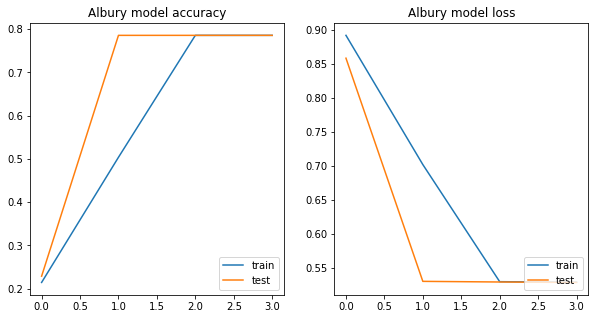

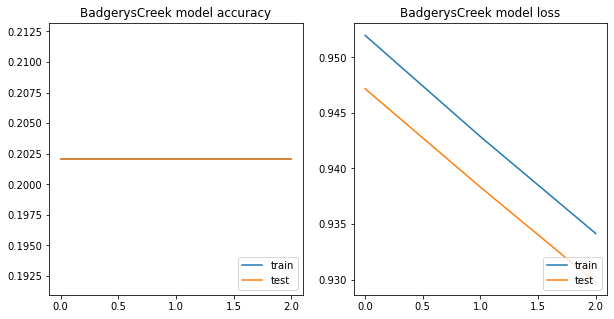

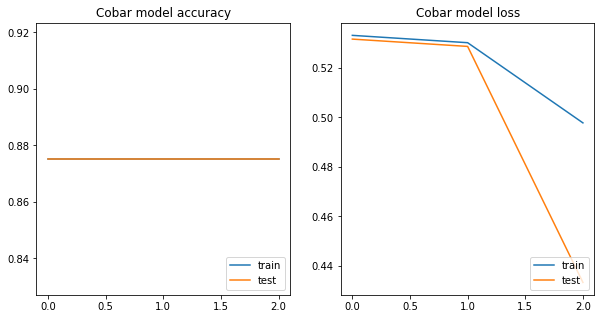

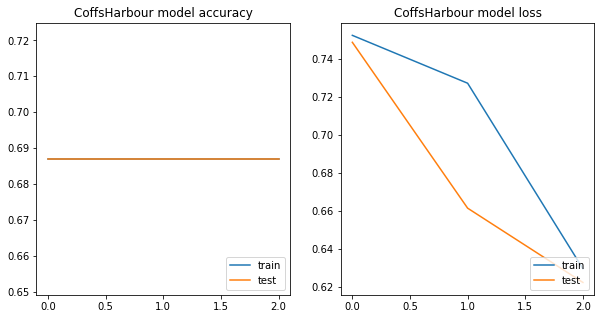

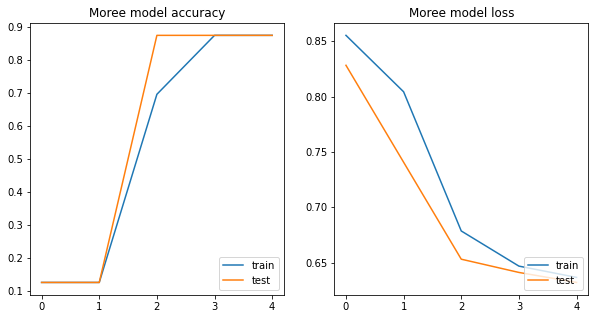

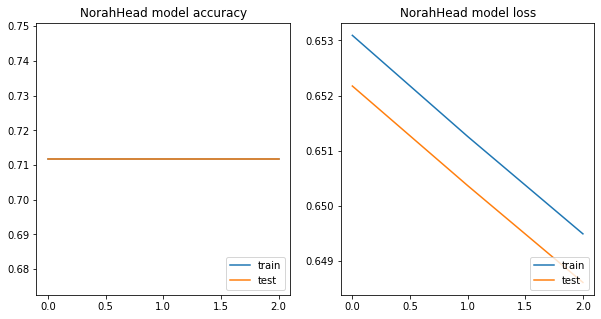

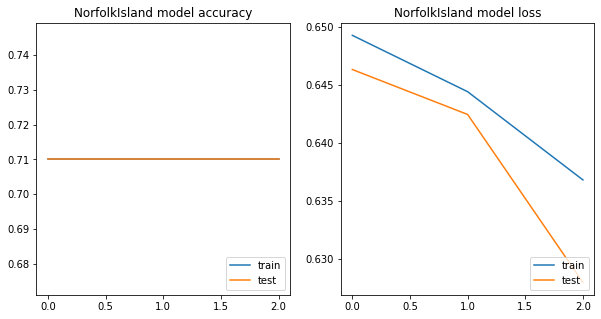

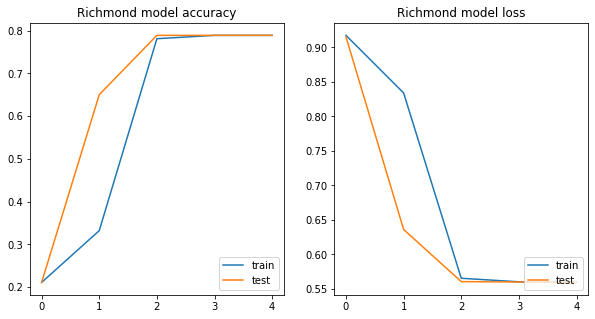

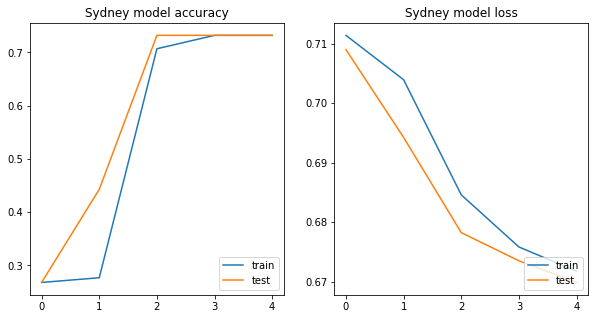

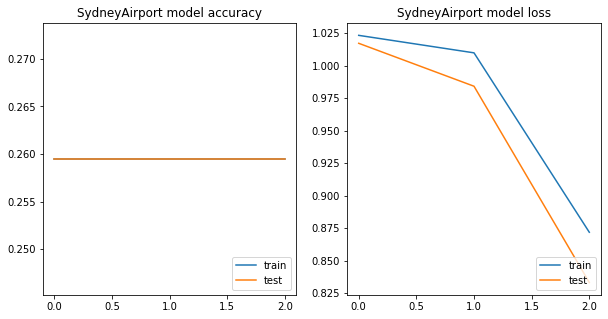

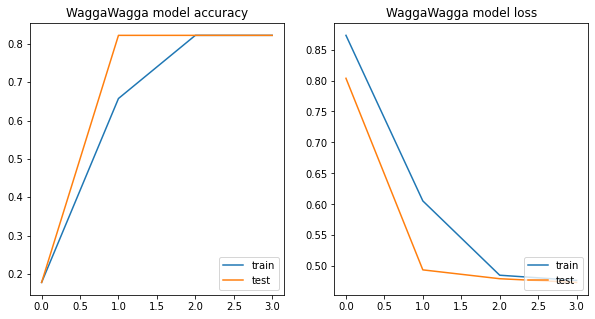

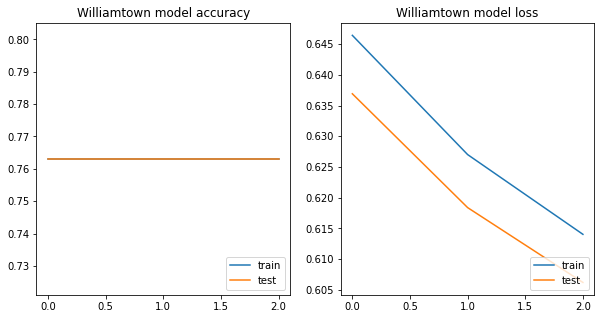

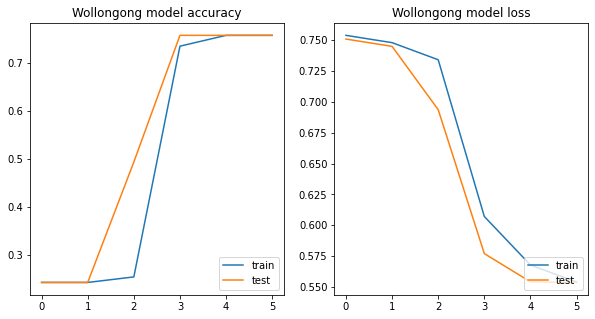

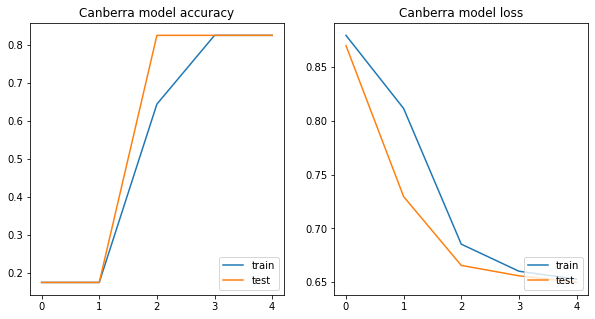

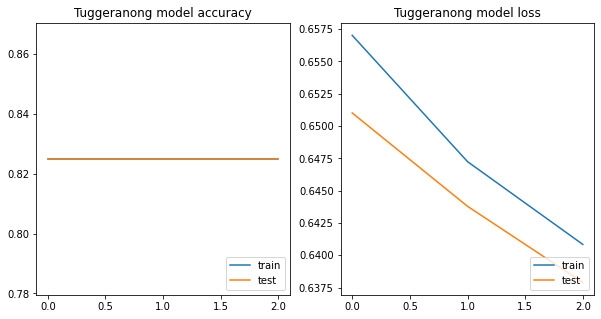

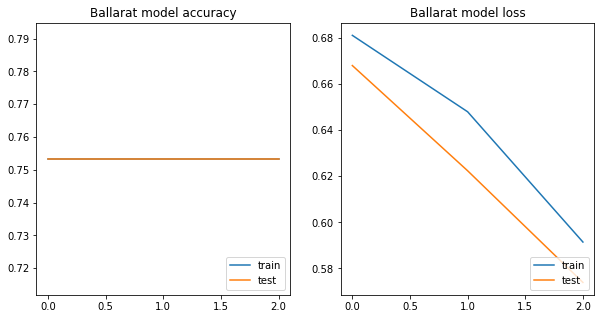

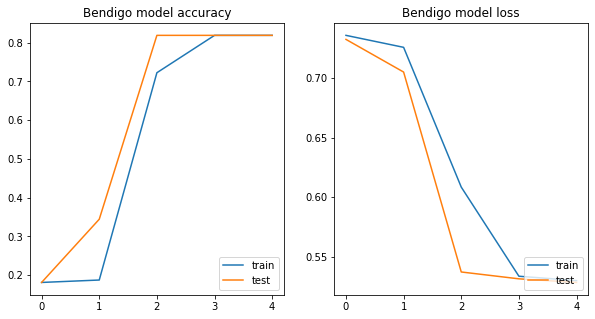

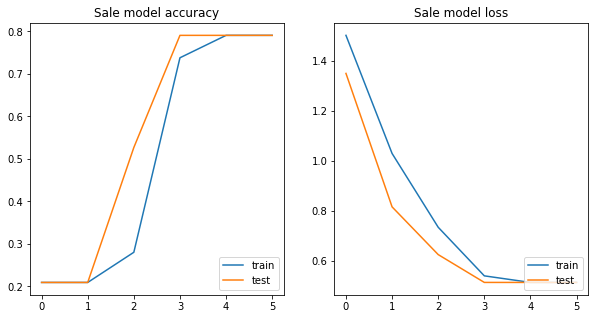

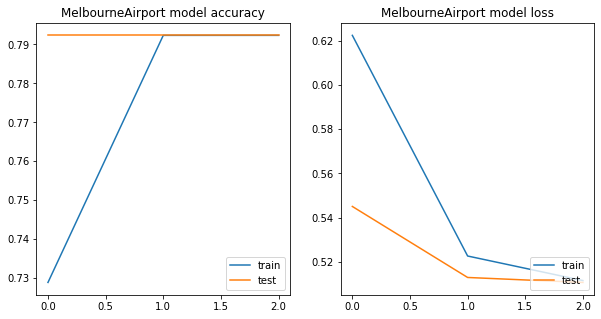

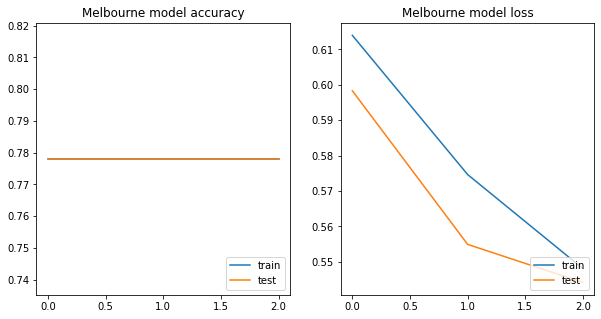

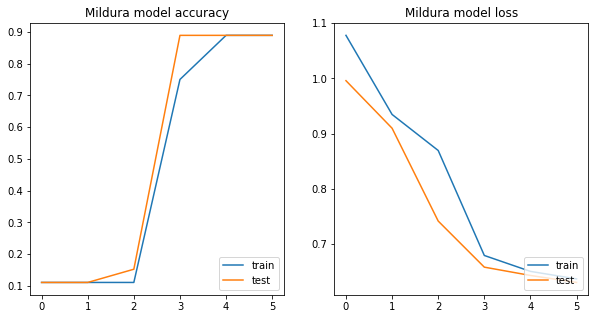

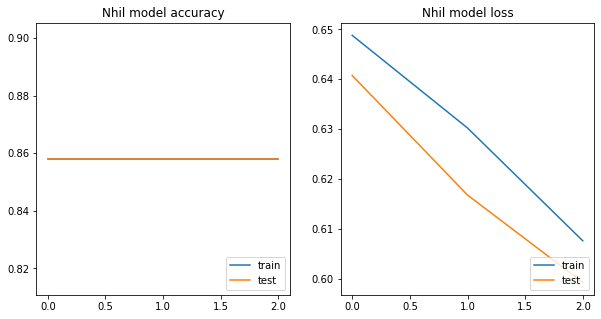

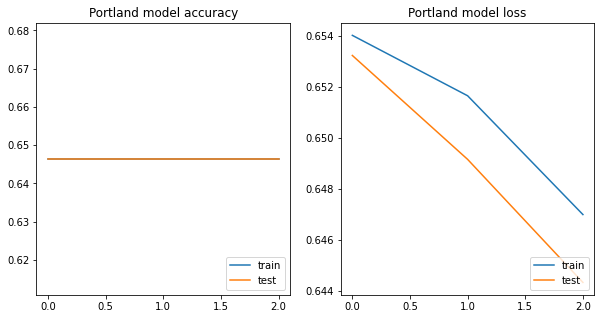

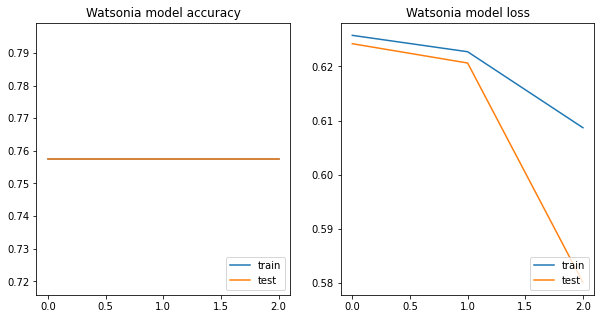

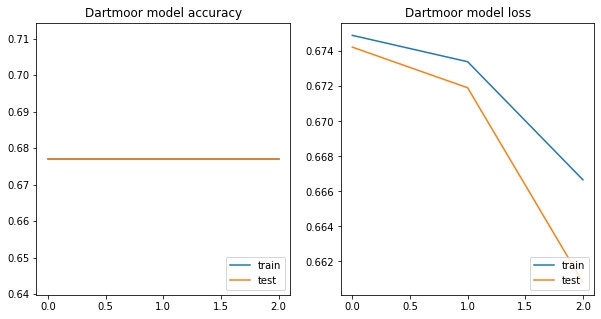

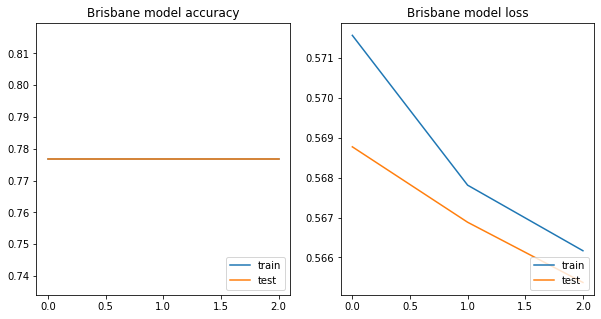

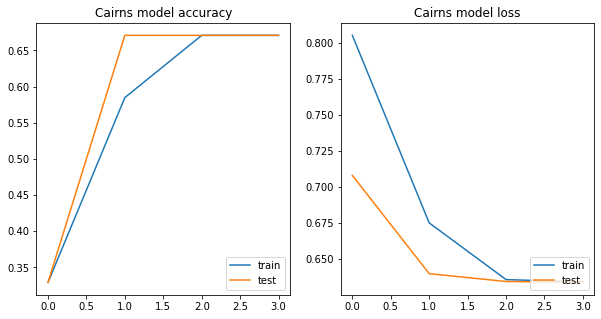

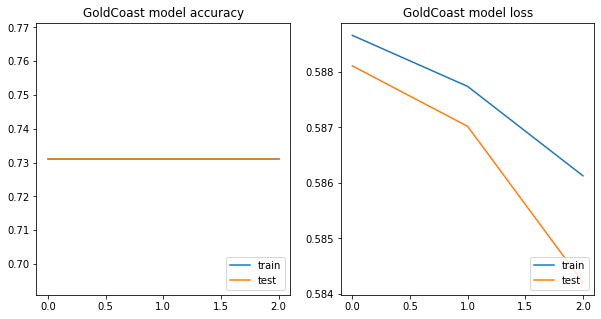

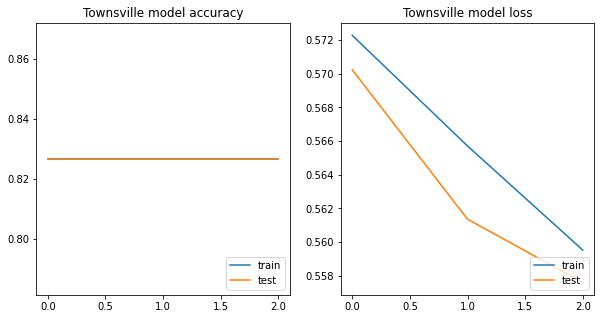

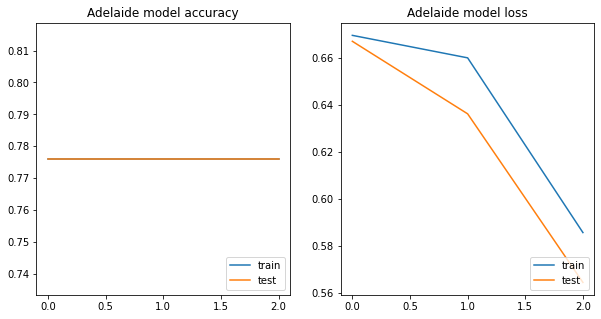

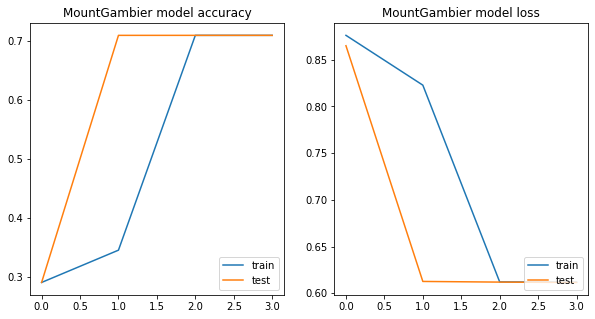

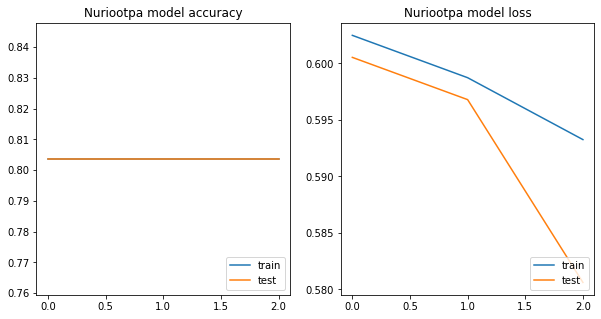

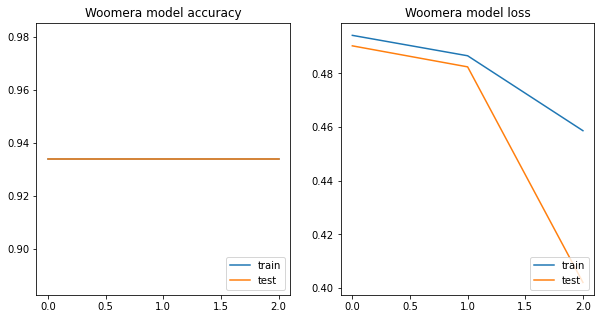

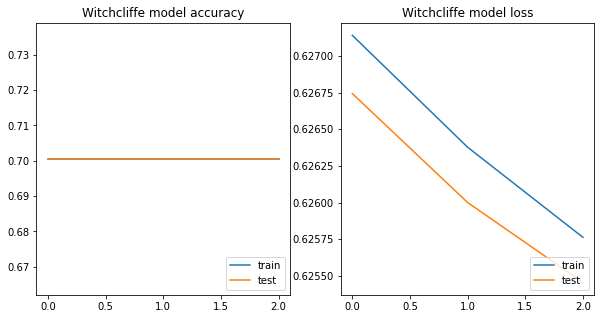

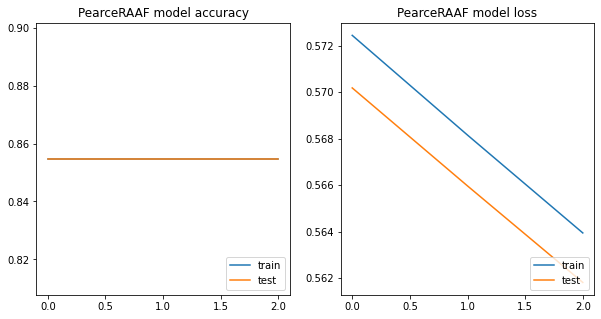

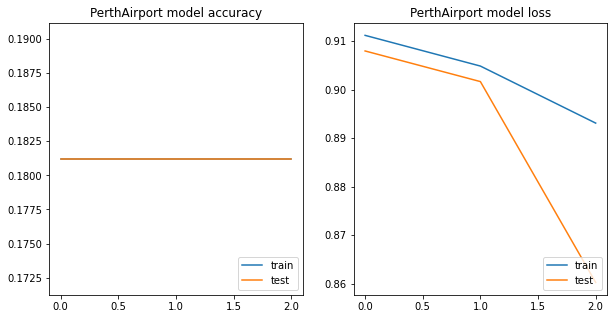

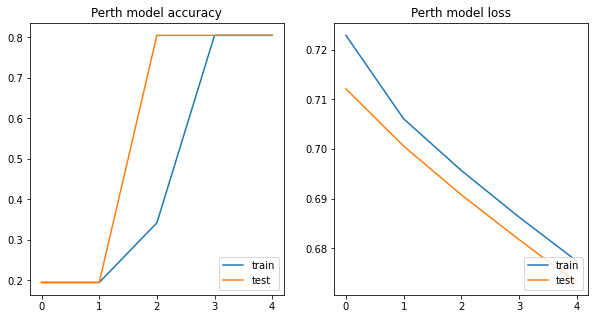

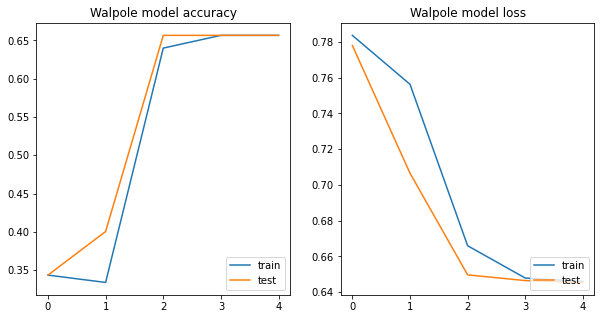

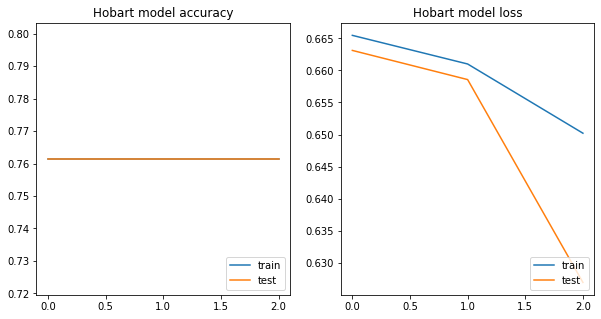

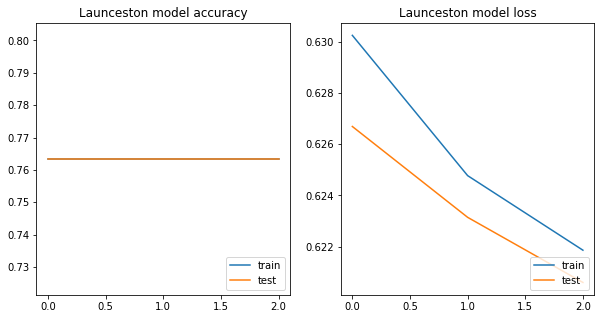

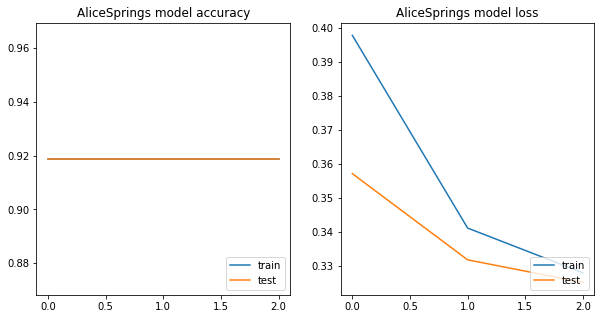

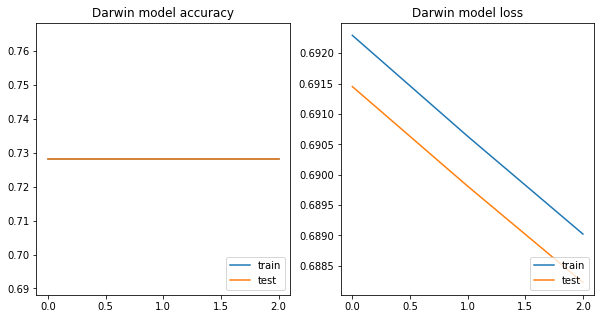

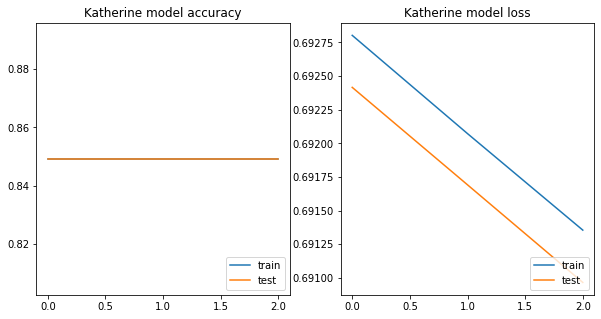

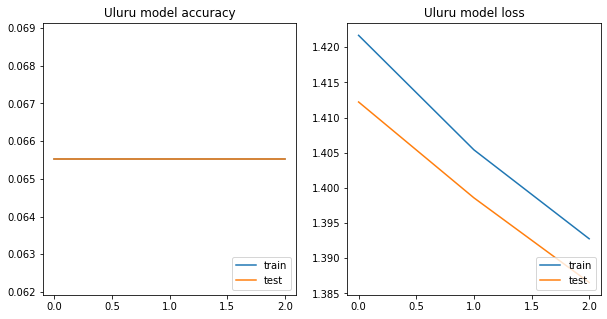

In [54]:
locs = list()
for l in locations:
    loc_data = train.copy(deep=True).loc[train['Location'] == l]
    loc_data = format_data(loc_data)
    
    if (loc_data.shape[0] == 0): continue
    locs.append(l)
    
    n = len(loc_data)
    train_df = loc_data
    val_df = loc_data    
    test_df = loc_data
    cols_to_norm = list(loc_data.columns)
    cols_to_norm.remove('RainToday')
    cols_to_norm.remove('RainTomorrow')

    train_mean = train_df[cols_to_norm].mean()
    train_std = train_df[cols_to_norm].std()

    train_df.loc[:,cols_to_norm] = (train_df.loc[:,cols_to_norm] - train_mean) / train_std
    val_df.loc[:,cols_to_norm] = (val_df.loc[:,cols_to_norm] - train_mean) / train_std
    test_df.loc[:,cols_to_norm] = (test_df.loc[:,cols_to_norm] - train_mean) / train_std
    
    lstm_model = tf.keras.models.Sequential([
#         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(4, return_sequences=False)),
        tf.keras.layers.LSTM(8, return_sequences=False),
        tf.keras.layers.Dense(units=1, activation='sigmoid'),    
    ])
    
    lr = 0.0001
    w = WindowGenerator(input_width=7, label_width=1, shift=1, train_df=train_df, test_df=test_df, val_df=val_df, label_columns=['RainTomorrow'])
    history = compile_and_fit(lstm_model, w, lr=lr)
    
    fname = rf'models/model_{l}.h5'
    lstm_model.save(fname)

    loss[l] = [ history.history['loss'],history.history['val_loss'] ]
    acc[l] = [ history.history['binary_accuracy'],history.history['val_binary_accuracy'] ]
    
#     results(lstm_model, l, w)
    plot_results(l)

In [8]:
e_train = train.copy(deep=True)
e_val = val.copy(deep=True)
e_train = format_data(e_train)
e_val = format_data(e_val)

n = len(e_train)
train_df = e_train
val_df = e_val
test_df = e_train[int(n*0.7):]

cols_to_norm = list(e_train.columns)
cols_to_norm.remove('RainToday')
cols_to_norm.remove('RainTomorrow')

train_mean = val_df[cols_to_norm].mean()
train_std = val_df[cols_to_norm].std()

train_df.loc[:,cols_to_norm] = (train_df.loc[:,cols_to_norm] - train_mean) / train_std
val_df.loc[:,cols_to_norm] = (val_df.loc[:,cols_to_norm] - train_mean) / train_std
test_df.loc[:,cols_to_norm] = (test_df.loc[:,cols_to_norm] - train_mean) / train_std
    
window = WindowGenerator(input_width=7, label_width=1, shift=1, train_df=train_df, test_df=test_df, val_df=val_df, label_columns=['RainTomorrow'])

/home/mqp/pyenv/lib/python3.7/site-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


In [10]:
locs = list()
for l in locations:
    loc_data = train.copy(deep=True).loc[train['Location'] == l]
    loc_data = format_data(loc_data)
    if (loc_data.shape[0] == 0): continue
    locs.append(l)

In [11]:
def load_all_models(successful_locs):
    all_models = list()
    for i in successful_locs:
        filename = rf'models/model_{i}.h5'
        model = keras.models.load_model(filename)
        all_models.append(model)
    return all_models

# successful_locs = ['Moree', 'Richmond', 'Sydney', 'WaggaWagga', 'Wollongong', 'Canberra', 'Bendigo', 'Sale', 'Mildura', 'Walpole']
# successful_locs = ['BadgerysCreek','Cobar','NorahHead', 'Bendigo', 'MelbourneAirport','Portland','Cairns','Uluru']
successful_locs = locs
members = load_all_models(successful_locs)

In [12]:
yhats = [model.predict(window.val) for model in members]
yhats = np.array(yhats)

Raw accuracy: 0.616894429174248
Sensitivity(ability to detect rain in rainy days): 27.76%
Specificity(ability to detect Not rain in normal days): 71.85%
f1 score: 0.25041660354491746


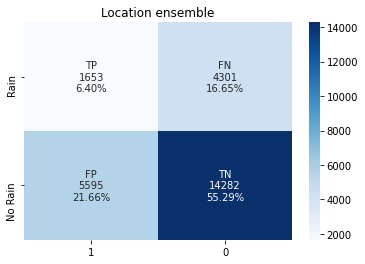

In [15]:
count = 0
ytrue = np.array(window.val_df[7:]['RainTomorrow'])

preds = np.mean(yhats, axis=0)
preds = preds.reshape(preds.shape[0])
preds = np.array([(x>0.5).astype("int32") for x in preds])

for i in range(0,preds.shape[0]):
    if ((preds[i]-ytrue[i])**2) == 0:
        count+=1
print(f'Raw accuracy: {count/preds.shape[0]}')
visual_cm(ytrue, preds, 'Location ensemble')

In [16]:
successful_locs = ['Moree', 'Richmond', 'Sydney', 'WaggaWagga', 'Wollongong', 'Canberra', 'Bendigo', 'Sale', 'Mildura', 'Walpole']
members = load_all_models(successful_locs)

yhats = [model.predict(window.val) for model in members]
yhats = np.array(yhats)

Raw accuracy: 0.5503077697340405
Sensitivity(ability to detect rain in rainy days): 41.12%
Specificity(ability to detect Not rain in normal days): 59.20%
f1 score: 0.29651162790697677


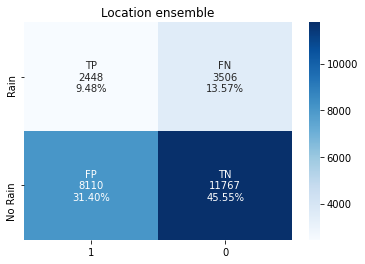

In [17]:
count = 0
ytrue = np.array(window.val_df[7:]['RainTomorrow'])

preds = np.mean(yhats, axis=0)
preds = preds.reshape(preds.shape[0])
preds = np.array([(x>0.5).astype("int32") for x in preds])

for i in range(0,preds.shape[0]):
    if ((preds[i]-ytrue[i])**2) == 0:
        count+=1
print(f'Raw accuracy: {count/preds.shape[0]}')
visual_cm(ytrue, preds, 'Location ensemble')